# Extended data figure 3
This notebook reproduces the GP regression plots provided in from extended data figure 3g.

In [1]:
import torch
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import GP regression code
from importlib import reload
import dli_gpr

%matplotlib inline

# Input data
Read input text files (provided in data directory of this repository).

In [2]:
data_dir = "data"

# data files (this figure only shows TE metacluster in responders.)
te_r_fname = os.path.join(data_dir, "v3_MetaclusterTE_R_gprinput.txt")

# read these with pandas (tsv)
te_r_df = pd.read_csv(te_r_fname, sep="\t")

# drop NaNs
te_r_df.dropna(inplace=True)

In [3]:
# check to make sure looks ok
te_r_df

,time,proportion(y),numcellsincluster(x),totalcellsinsample(n),patientID,sampleID,tumorburden
0,-30,0.0000,1,329,DFCI-5310,1,94.0
1,180,0.0931,21,1310,DFCI-5310,2,0.0
2,-42,0.1725,127,2834,DFCI-5309,5,11.0
3,90,0.0808,88,2030,DFCI-5309,6,0.0
4,0,0.3389,7,3184,DFCI-5311,9,44.0
6,90,0.2036,32,3762,DFCI-5311,11,0.0
7,270,0.0487,24,8662,DFCI-5311,12,0.0
8,0,0.4367,116,1358,DFCI-5312,21,38.0
9,270,0.0000,1,13,DFCI-5312,22,0.0
10,-5,0.1644,10,1174,DFCI-5317,23,80.0


# Prepare GPR input for tumor burden
This is a regular GPR model. We use the same bandwidth for all models, use SE of the data to initialize the variance.

In [6]:
reload(dli_gpr)

# get times
time_r = te_r_df["time"].values
tb_r = te_r_df["tumorburden"].values/100.

# convert everything to torch tensors
torch_time_r = torch.FloatTensor(time_r)
torch_tb_r = torch.FloatTensor(tb_r)

# initialize models
tb_r_model = dli_gpr.gpr(torch_time_r, torch_tb_r)

# have to initialize kernel
tb_r_model.initialize_variables()

In [7]:
# optimize sigma by max likelihood
pyro.clear_param_store()
tb_r_losses = tb_r_model.optimize(n_steps=5000)

100%|██████████| 5000/5000 [00:05<00:00, 933.05it/s] 


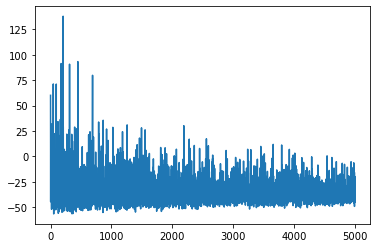

In [8]:
# make sure looks like it is actually converging
plt.plot(tb_r_losses)

In [9]:
# get predictions for new points...
# new input time points
new_y = torch.FloatTensor(np.linspace(-600, 1200, 100))

# compute conditional distribution of response variable
tb_r_mean, tb_r_cov = tb_r_model.conditional_distribution(new_y)

In [10]:
# prepare values for plotting

# time points as numpy array
new_times = new_y.numpy()

# means
tb_r_mean = tb_r_mean.numpy()

# variance
tb_r_var = torch.diag(tb_r_cov).numpy()

Text(0.5, 1.0, 'Tumor burden (Responders)')

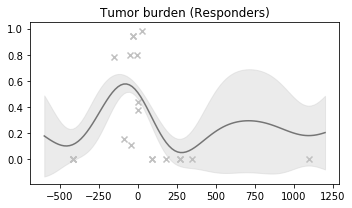

In [12]:
# make plots
fig, ax = plt.subplots(1,1, figsize=(5,3), tight_layout=True)

# plot tumor burden for R
ax.plot(new_times, tb_r_mean, "k-", alpha=0.5)
ax.scatter(time_r, tb_r, c="silver", marker="x")
ax.fill_between(new_times, tb_r_mean + tb_r_var, tb_r_mean - tb_r_var, color="silver", alpha=0.3)
ax.set_title("Tumor burden (Responders)")

# Metacluster models
This is the hierarchical model for heteroskedascic noise.

In [14]:
# prepare input (numpy arrays)
te_r = te_r_df["proportion(y)"].values

# convert to torch tensors
torch_te_r = torch.FloatTensor(te_r)

In [15]:
# get relative weights for each
sizes_r = te_r_df["totalcellsinsample(n)"].values

# convert to torch
torch_sizes_r = torch.FloatTensor(sizes_r)

In [33]:
# initialize models
reload(dli_gpr)

# gp regression
te_r_vanilla = dli_gpr.gpr(torch_time_r, torch_te_r)

# modified model
te_r_model = dli_gpr.dli_gpr(torch_time_r, torch_te_r, torch_sizes_r)

# initialize variables
te_r_model.initialize_variables()
te_r_vanilla.initialize_variables()

In [34]:
for model in [te_r_model, te_r_vanilla]:
    pyro.clear_param_store()
    model.optimize(n_steps=5000);

100%|██████████| 5000/5000 [00:05<00:00, 978.88it/s] 


In [35]:
# compute conditional distribution of response variable
te_r_mean, te_r_cov = te_r_model.conditional_distribution(new_y)
te_r_vanilla_mean, te_r_vanilla_cov = te_r_vanilla.conditional_distribution(new_y)

In [36]:
# convert back to numpy array for plotting
te_r_mean, te_r_var = te_r_mean.numpy(), np.diag(te_r_cov.numpy())
te_r_vanilla_mean, te_r_vanilla_var = te_r_vanilla_mean.numpy(), np.diag(te_r_vanilla_cov.numpy())

In [40]:
# get metacell cluster sizes for plotting
plotting_sizes_r = sizes_r/40

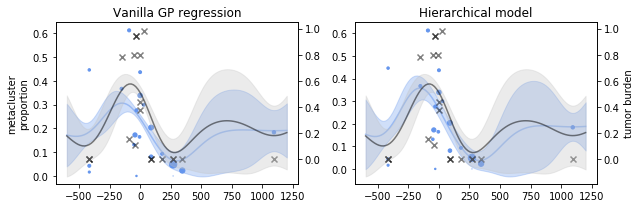

In [42]:
# make plots
fig, ax = plt.subplots(1,2, figsize=(9,3), tight_layout=True)

# plot metacluster TE for R
ax[1].plot(new_times, te_r_mean, "cornflowerblue", alpha=0.5)
ax[1].scatter(time_r, te_r, c="cornflowerblue", marker=".", sizes=plotting_sizes_r)
ax[1].fill_between(new_times, te_r_mean + te_r_var, te_r_mean - te_r_var, color="cornflowerblue", alpha=0.3)
ax[1].set_title("Hierarchical model")

# plot metacluster TE for NR
ax[0].plot(new_times, te_r_vanilla_mean, c="cornflowerblue", alpha=0.5)
ax[0].scatter(time_r, te_r, c="cornflowerblue", marker=".", sizes=plotting_sizes_r)
ax[0].fill_between(new_times, 
                   te_r_vanilla_mean + te_r_vanilla_var, 
                   te_r_vanilla_mean - te_r_vanilla_var, color="cornflowerblue", alpha=0.3)
ax[0].set_title("Vanilla GP regression")

# add duplicated axis to plot tumor burden for R
for ix in range(2):
    ax2 = ax[ix].twinx()
    ax2.plot(new_times, tb_r_mean, "k-", alpha=0.5)
    ax2.scatter(time_r, tb_r, c="k", marker="x", alpha=0.5)
    ax2.fill_between(new_times, tb_r_mean + tb_r_var, tb_r_mean - tb_r_var, color="silver", alpha=0.3)
    if ix==1:
        ax2.set_ylabel("tumor burden")
    if ix==0:
        ax[ix].set_ylabel("metacluster\nproportion")
        
# save figure
# plt.savefig("extended3g.pdf")